In [63]:
# Step 1: Install all necessary packages

#pip install requests
#pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import numpy as np

In [3]:
# For reference, CIKs for both DDOG and BILL

bill_cik = "0001786352"
ddog_cik = "0001561550"

In [4]:
# Bulk pull of all available metrics that EDGAR offers for the company - use this to find the topline figure + inputs to FCF
# Ideally you can plug this output into ChatGPT and ask what the topline, Operating Cashflow, and Capex figures are named, worked really well for me

EDGAR_BASE_URL = "https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json"
HEADERS = {"User-Agent": "MyPersonalProject leland.speth@gmail.com"}

def get_all_metrics(cik):
    """Fetch all available GAAP metrics for a given company from the SEC EDGAR API."""
    url = EDGAR_BASE_URL.format(cik=cik)
    response = requests.get(url, headers=HEADERS)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching metrics for CIK {cik}: {response.status_code}")
        return None

cik = "0001786352".zfill(10)

data = get_all_metrics(cik)

if data:
    metrics = list(data.get('facts', {}).get('us-gaap', {}).keys())
    #print("Available Metrics:", metrics)


In [5]:
# Pull in key metrics from EDGAR
# Next we will pull the specified metrics for the CIK we want (DDOG in this case), controlling for fiscal year end date differences
# Also built this to be scalable if companies use different metric names for Revenue/Operating Cashflow/Capex

# Editable Fields Start ----

company_name = "DDOG"  # Used for CSV Name
cik = "0001561550" # Can be found on Company Filings
fiscal_year_end = "12/31"  # Don't need year, just DD/YY


revenue_metric = "RevenueFromContractWithCustomerExcludingAssessedTax"
operating_cashflow_metric = "NetCashProvidedByUsedInOperatingActivities"
capex_ppe_metric = "PaymentsToAcquirePropertyPlantAndEquipment"
capex_software_metric = "PaymentsToDevelopSoftware"


FISCAL_YEAR_MAPPING = {
    "12/31": {1: "current", 2: "current", 3: "current", 4: "current"},
    "9/30": {1: "next", 2: "current", 3: "current", 4: "current"},
    "6/30": {1: "next", 2: "next", 3: "current", 4: "current"},
    "3/31": {1: "next", 2: "next", 3: "next", 4: "current"},
    "1/31": {1: "next", 2: "next", 3: "next", 4: "current"}
}

# Editable Fields End ---

EDGAR_BASE_URL = "https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json"
HEADERS = {"User-Agent": "MyPersonalProject leland.speth@gmail.com"}

def get_company_facts(cik):
    url = EDGAR_BASE_URL.format(cik=cik)
    response = requests.get(url, headers=HEADERS)
    
    if response.status_code == 200:
        return response.json()
    return None

def get_fiscal_quarter(date):
    fiscal_year_end_month = int(fiscal_year_end.split("/")[0])
    fiscal_q4_months = [fiscal_year_end_month]
    fiscal_q3_months = [(fiscal_year_end_month - 3) % 12 or 12]
    fiscal_q2_months = [(fiscal_year_end_month - 6) % 12 or 12]
    fiscal_q1_months = [(fiscal_year_end_month - 9) % 12 or 12]
    
    if date.month in fiscal_q4_months:
        return 4
    elif date.month in fiscal_q3_months:
        return 3
    elif date.month in fiscal_q2_months:
        return 2
    elif date.month in fiscal_q1_months:
        return 1
    return None

def get_fiscal_year(date, quarter):
    year_adjustment = FISCAL_YEAR_MAPPING.get(fiscal_year_end, {}).get(quarter, "current")
    return date.year + 1 if year_adjustment == "next" else date.year

def extract_metric(data, metric_name, rename_col):
    metric_data = data.get("facts", {}).get("us-gaap", {}).get(metric_name, {}).get("units", {}).get("USD", [])
    
    if metric_data:
        df = pd.DataFrame(metric_data)
        df = df[["end", "val"]].rename(columns={"val": rename_col})
        df = df.drop_duplicates(subset=["end"], keep="last")
        df["end"] = pd.to_datetime(df["end"])
        df["quarter"] = df["end"].apply(get_fiscal_quarter)
        df["year"] = df.apply(lambda row: get_fiscal_year(row["end"], row["quarter"]), axis=1)
        return df
    return None

def convert_ytd_to_quarterly(df, column_name):
    if df is None or df.empty:
        return df
    quarterly_df = df.copy()
    for year in df["year"].unique():
        year_data = df[df["year"] == year].sort_values("quarter")
        if len(year_data) > 1:
            prev_val = 0
            for _, row in year_data.iterrows():
                ytd_val = row[column_name]
                quarterly_val = ytd_val - prev_val
                idx = quarterly_df[(quarterly_df["year"] == year) & (quarterly_df["quarter"] == row["quarter"])].index
                quarterly_df.loc[idx, column_name] = quarterly_val
                prev_val = ytd_val
    return quarterly_df

def adjust_fiscal_q4_revenue(df):
    adjusted_df = df.copy()
    for year in df["year"].unique():
        q4_mask = (df["year"] == year) & (df["quarter"] == 4)
        q1_to_q3_mask = (df["year"] == year) & (df["quarter"].isin([1, 2, 3]))
        if any(q4_mask) and any(q1_to_q3_mask):
            annual_total = df.loc[q4_mask, "Revenue"].values[0]
            q1_to_q3_sum = df.loc[q1_to_q3_mask, "Revenue"].sum()
            q4_value = annual_total - q1_to_q3_sum
            adjusted_df.loc[q4_mask, "Revenue"] = q4_value
    return adjusted_df

data = get_company_facts(cik)

if data:
    revenue_df = extract_metric(data, revenue_metric, "Revenue")
    operating_cash_flow_df = extract_metric(data, operating_cashflow_metric, "Operating Cashflow")
    capex_ppe_df = extract_metric(data, capex_ppe_metric, "CapEx (PPE)")
    capex_software_df = extract_metric(data, capex_software_metric, "CapEx (Software)")

    if revenue_df is not None:
        revenue_df = adjust_fiscal_q4_revenue(revenue_df)
    if operating_cash_flow_df is not None:
        operating_cash_flow_df = convert_ytd_to_quarterly(operating_cash_flow_df, "Operating Cashflow")
    if capex_ppe_df is not None:
        capex_ppe_df = convert_ytd_to_quarterly(capex_ppe_df, "CapEx (PPE)")
    if capex_software_df is not None:
        capex_software_df = convert_ytd_to_quarterly(capex_software_df, "CapEx (Software)")

    metrics_df = pd.DataFrame()

    if revenue_df is not None:
        metrics_df = revenue_df[["end", "year", "quarter", "Revenue"]].copy()

    for df, col_name in [(operating_cash_flow_df, "Operating Cashflow"),
                         (capex_ppe_df, "CapEx (PPE)"),
                         (capex_software_df, "CapEx (Software)")]:
        if df is not None:
            if metrics_df.empty:
                metrics_df = df[["end", "year", "quarter", col_name]].copy()
            else:
                metrics_df = metrics_df.merge(df[["end", "year", "quarter", col_name]], on=["end", "year", "quarter"], how="outer")

    if not metrics_df.empty:
        metrics_df["FreeCashFlow"] = (
            metrics_df["Operating Cashflow"].fillna(0) - 
            (metrics_df["CapEx (PPE)"].fillna(0) +
             metrics_df["CapEx (Software)"].fillna(0))
        )

    metrics_df = metrics_df.sort_values("end")

    filename = f"Edgar_consolidated_metrics_{company_name}.csv"
    metrics_df.to_csv(filename, index=False)
    print(f"Extracted metrics saved as '{filename}'.")
else:
    print("Failed to retrieve data from SEC EDGAR API.")


Extracted metrics saved as 'Edgar_consolidated_metrics_DDOG.csv'.


In [6]:
# Toggle to enable/disable overrides
# I noticed there is some lumpiness in the EDGAR data from before the company was public (figures are annual for 2017/2018)
# Created this script to merge certain rows with the CSV given for case study when needed

apply_overrides = True  # Set to False to ignore this cell

if apply_overrides:

    metrics_file = f"Edgar_consolidated_metrics_{company_name}.csv"
    metrics_df = pd.read_csv(metrics_file)
    
    metrics_df["end"] = pd.to_datetime(metrics_df["end"], errors='coerce').dt.date

    candidate_file = "CANDIDATE_DATASET.csv"
    candidate_df = pd.read_csv(candidate_file)

    transformed_data = []
    for idx, row in candidate_df.iterrows():
        for col in candidate_df.columns:
            parts = str(row[col]).split(";;;;;;;")
            if len(parts) >= 4:
                value = parts[0]
                company_info = parts[-1]
                exchange, company_id = company_info.split(":") if ":" in company_info else (None, company_info)
                if len(col) >= 6:
                    year = int(col[:4])
                    quarter = int(col[4:].replace("Q", ""))
                    transformed_data.append({
                        "Metric_ID": idx + 1, 
                        "Exchange": exchange,
                        "Company_ID": company_id,
                        "Year": year,
                        "Quarter": quarter,
                        "Value": float(value) if value.replace('.', '', 1).isdigit() else None
                    })

    transformed_df = pd.DataFrame(transformed_data)

    scale_factor = 1000 
    transformed_df["Value"] *= scale_factor

    # Define modifications: specify Metric_ID, Year, Quarter, and metric name
    modifications = [
        {"Metric_ID": 7, "Year": 2017, "Quarter": 1, "Metric": "Revenue"},
        {"Metric_ID": 7, "Year": 2017, "Quarter": 2, "Metric": "Revenue"},
        {"Metric_ID": 7, "Year": 2017, "Quarter": 3, "Metric": "Revenue"},
        {"Metric_ID": 7, "Year": 2017, "Quarter": 4, "Metric": "Revenue"},
        {"Metric_ID": 7, "Year": 2018, "Quarter": 1, "Metric": "Revenue"},
        {"Metric_ID": 7, "Year": 2018, "Quarter": 2, "Metric": "Revenue"},
        {"Metric_ID": 7, "Year": 2018, "Quarter": 3, "Metric": "Revenue"},
        {"Metric_ID": 7, "Year": 2018, "Quarter": 4, "Metric": "Revenue"},
    ]

    # Remove old rows that will be replaced
    for modification in modifications:
        metrics_df = metrics_df[~((metrics_df["year"] == modification["Year"]) & (metrics_df["quarter"] == modification["Quarter"]))]

    month_end_days = {
        1: "01-31", 2: "02-28", 3: "03-31", 4: "04-30", 5: "05-31", 6: "06-30",
        7: "07-31", 8: "08-31", 9: "09-30", 10: "10-31", 11: "11-30", 12: "12-31"
    }

    # Apply overrides and additions
    for modification in modifications:
        mask = (
            (transformed_df["Metric_ID"] == modification["Metric_ID"]) &
            (transformed_df["Year"] == modification["Year"]) &
            (transformed_df["Quarter"] == modification["Quarter"])
        )
        new_value = transformed_df.loc[mask, "Value"].values[0] if not transformed_df.loc[mask, "Value"].empty else None

        if new_value is not None:
            quarter_month = modification['Quarter'] * 3  # Approximate end of the quarter
            end_date = f"{modification['Year']}-{month_end_days[quarter_month]}"
            new_row = {
                "year": modification["Year"],
                "quarter": modification["Quarter"],
                "end": pd.to_datetime(end_date).date(),  # Correct month-end dates
                modification["Metric"]: new_value
            }
            metrics_df = pd.concat([metrics_df, pd.DataFrame([new_row])], ignore_index=True)
    
    metrics_df = metrics_df.sort_values(by=["end"]).reset_index(drop=True)
    
    updated_filename = f"Edgar_consolidated_metrics_{company_name}_updated.csv"
    metrics_df.to_csv(updated_filename, index=False)
    print(f"Updated dataset saved as '{updated_filename}'")


Updated dataset saved as 'Edgar_consolidated_metrics_DDOG_updated.csv'


In [7]:
# Next we will manually calculate some key metrics including ARR, Net New ARR, ARR Growth Rate, and FCF% 

df = pd.read_csv(updated_filename)

df["ARR"] = df["Revenue"] * 4

df["Net New ARR"] = df["ARR"].diff()

df["ARR Growth"] = df.groupby("quarter")["ARR"].pct_change()

df["FCF %"] = df["FreeCashFlow"] / df["Revenue"]

df["Rule of X"] = (df["ARR Growth"] * 100 + df["FCF %"] * 100).round(0)

output_filename = f"Edgar_consolidated_metrics_{filename.split('_')[-1].replace('.csv', '')}_with_calcs.csv"
df.to_csv(output_filename, index=False)

print(f"Updated metrics saved as '{output_filename}'")


Updated metrics saved as 'Edgar_consolidated_metrics_DDOG_with_calcs.csv'


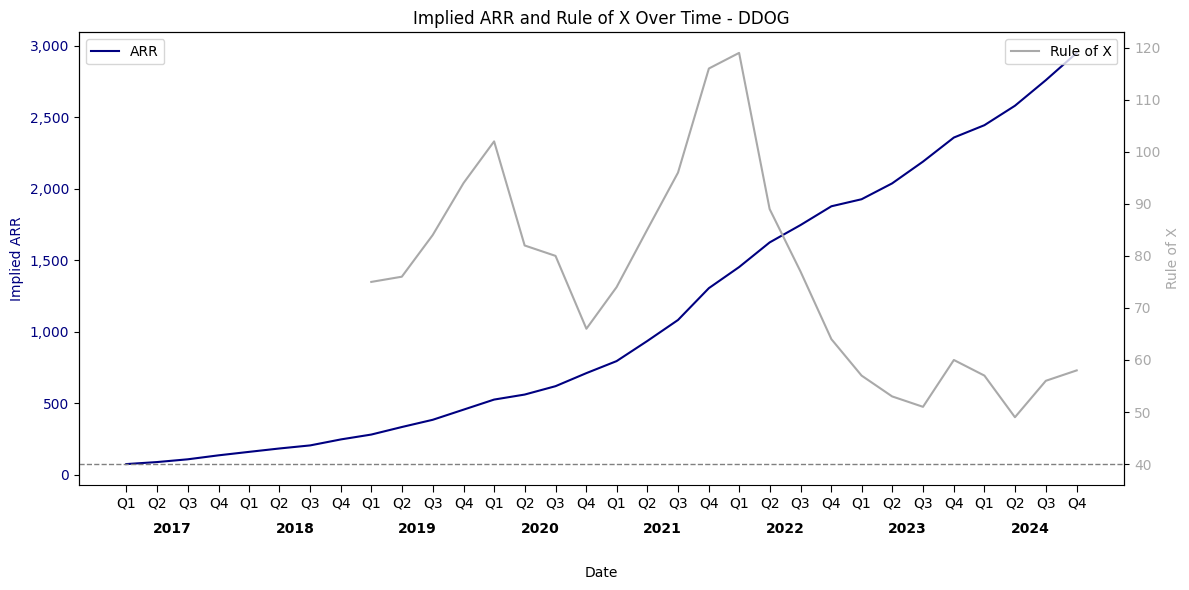

In [8]:
# Finally we will plot the data we stipulate while formatting the graph to our liking
# We will include a toggle to manually start the graph at a specified quarter in case there is any lumpiness in data or specificity is needed

# Editable Fields Start ----

start_date_filter = True 
start_quarter = 1 
start_year = 2017

# Editable Fields End ----


output_filename = f"Edgar_consolidated_metrics_{filename.split('_')[-1].replace('.csv', '')}_with_calcs.csv"
df = pd.read_csv(output_filename)

df["end"] = pd.to_datetime(df["end"], format="%Y-%m-%d")

if start_date_filter:
    df = df[(df["year"] > start_year) | ((df["year"] == start_year) & (df["quarter"] >= start_quarter))]

fig, ax1 = plt.subplots(figsize=(12, 6)) 

ax1.set_xlabel("Date", labelpad=40) 
ax1.set_ylabel("Implied ARR", color="navy")
ax1.plot(df["end"], df["ARR"] / 1e6, label="ARR", color="navy", linestyle="solid")
#ax1.plot(df["end"], df["Net New ARR"] / 1e6, label="Net New ARR", color="#4F94CD", linestyle="solid")  # Took out NNARR for now
ax1.tick_params(axis="y", labelcolor="navy")
ax1.legend(loc="upper left")
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))


ax2 = ax1.twinx()
ax2.set_ylabel("Rule of X", color="darkgray")
ax2.plot(df["end"], df["Rule of X"], label="Rule of X", color="darkgray", linestyle="solid")
ax2.tick_params(axis="y", labelcolor="darkgray")
ax2.legend(loc="upper right")
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))

target_value = 40
ax2.axhline(y=target_value, color="gray", linestyle="dashed", linewidth=1)


year_labels = df["year"].astype(str).unique()
year_positions = df.groupby("year")["end"].mean().values
quarters = [f"Q{q}" for q in df["quarter"]]

ax1_secondary = ax1.secondary_xaxis("bottom")
ax1.set_xticks(df["end"]) 
ax1.set_xticklabels(quarters, rotation=0)
ax1_secondary.spines['bottom'].set_position(('outward', 20))
ax1.spines['bottom'].set_color('white')
ax1_secondary.spines['bottom'].set_color('white')
ax1_secondary.spines['bottom'].set_color('white') 


ax1_secondary.set_xticks(year_positions)
ax1_secondary.set_xticklabels(year_labels, fontsize=10, fontweight='bold', ha='center')
ax1_secondary.tick_params(axis='x', which='both', bottom=False, top=False)

ax1.tick_params(axis='x', which='both', length=5, color='black')

ax1.grid(False)
ax2.grid(False)

plt.title(f"Implied ARR and Rule of X Over Time - {filename.split('_')[-1].replace('.csv', '')}")
plt.tight_layout()

# Show the plot
plt.show()
